In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/09/15 19:21:30 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/09/15 19:21:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/15 19:21:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
base_path = "/data/saturation/thesis_run_20240726_single_sims/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 16

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
    "mnnd",
    "z",
    "za",
    "radius_mean",
    "radius_stdev",
    F.col("areal_density").alias("ad"),
    F.log10("mnnd").alias("log_mnnd"),
    F.log10("nobs").alias("log_nobs"),
    F.log10("ntot").alias("log_ntot"),
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [5]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

In [6]:
def plot_metric(
    data: pd.DataFrame,
    x_var: str,
    x_label: str,
    y_var: str,
    y_label: str,
    dotted_horizontal_lines: list[float] = None
):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    simulation_ids = data.simulation_id.drop_duplicates()
    for idx, simulation_id in enumerate(simulation_ids):
        data_subset = data[data.simulation_id == simulation_id].sort_values("ntot")
        ax.plot(
            data_subset[x_var],
            data_subset[y_var],
            c=colors[idx % len(colors)],
            ls=line_styles[idx % len(line_styles)]
        )

    if dotted_horizontal_lines:
        for y_val in dotted_horizontal_lines:
            ax.axhline(y_val, color="r", linestyle="--")
    
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)

    return fig


def get_states_at_ntots(
    *,
    simulation_id: int,
    configs_dict: Dict,
    base_path: str,
    target_ntots: Optional[List[int]]=None,
    max_ntot: Optional[int]=int(1e6)
) -> Dict[int, pd.DataFrame]:
    """
    Returns a dict from values of ntot (a moment in time) to a dataframe of crater locations and radii at that time.
    """
    n_states = 25
    
    if not target_ntots:  
        target_ntots = [int(10**2 * 10**((x + 1) / n_states * (np.log10(max_ntot) - 2))) for x in range(n_states)]
        
    study_region_size = configs_dict[simulation_id]["study_region_size"]
    study_region_padding = configs_dict[simulation_id]["study_region_padding"]
    
    sim_name = configs_dict[simulation_id]["simulation_name"]
    sim_path = f"{base_path}/{sim_name}"
    
    stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
    craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
    removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")
    
    return {
        x: get_state_at_time(
            stats_df,
            craters_df,
            removals_df,
            simulation_id,
            x,
            study_region_size,
            study_region_padding,
            spark
        )
        for x in target_ntots
    }


def estimate_slopes_for_states(states: Dict[int, pd.DataFrame], simulation_id: int) -> pd.DataFrame:
    estimates = []
    for ntot, state in states.items():
        state = states[ntot]
        alpha, sigma = estimate_cumulative_slope(
            state.radius,
            configs_dict[simulation_id]["min_crater_radius"],
            state.radius.max(),
            min_search_slope=0.0,
            max_search_slope=10.0)
        estimates.append({
            "ntot": ntot,
            "alpha": alpha,
            "sigma": sigma,
        })
    return pd.DataFrame(estimates)


def plot_slope_estimates(estimates_df: pd.DataFrame):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    ax.errorbar(
        estimates_df.ntot,
        estimates_df.alpha,
        estimates_df.sigma,
        ls="None",
        marker="+"
    )
    ax.set_xlabel("$N_{tot}$", fontsize=font_size)
    ax.set_ylabel("$b$", fontsize=font_size)
    ax.set_xscale("log")
    
    return fig


def plot_metrics(
    *,
    df: pd.DataFrame,
    scenario_name: str,
    ntot_bound_saturation: int
):
    ad_line = df[df.ntot > ntot_bound_saturation].ad.mean()
    print(f"AD line: {ad_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "ad",
        "$A_d$",
        dotted_horizontal_lines=[ad_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_ad.png", bbox_inches="tight")
    
    log_mnnd_line = df[df.ntot > ntot_bound_saturation].log_mnnd.mean()
    print(f"log_mnnd line: {log_mnnd_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "log_mnnd",
        "$log_{10}(\\overline{NN}_d)$",
        dotted_horizontal_lines=[log_mnnd_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_mnnd.png", bbox_inches="tight")
    
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "z",
        "$Z$",
        dotted_horizontal_lines=[-1.96, 1.96]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_z.png", bbox_inches="tight")
    
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "za",
        "$Z_a$",
        dotted_horizontal_lines=[-1.96, 1.96]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_za.png", bbox_inches="tight")
    
    radius_mean_line = df[df.ntot > ntot_bound_saturation].radius_mean.mean()
    print(f"radius_mean line: {radius_mean_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "radius_mean",
        "$\\overline{r}$",
        dotted_horizontal_lines=[radius_mean_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_radius_mean.png", bbox_inches="tight")
    
    radius_stdev_line = df[df.ntot > ntot_bound_saturation].radius_stdev.mean()
    print(f"radius_stdev line: {radius_stdev_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "radius_stdev",
        "$\\sigma_r$",
        dotted_horizontal_lines=[radius_stdev_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_radius_stdev.png", bbox_inches="tight")

In [7]:
def get_lifetimes_for_simulation(
    simulation_id: int,
    base_path: str,
    sample_fraction: float
) -> pd.DataFrame:
    craters = spark.read.parquet(f"{base_path}/*/craters_*.parquet").sample(sample_fraction)
    removals = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")
    configs_df = F.broadcast(create_configs_df(read_configs(base_path, spark, completed_only=False)))
    
    configs_df.createOrReplaceTempView("config")
    craters.createOrReplaceTempView("craters")
    removals.createOrReplaceTempView("removals")
    
    query = f"""
    WITH lifetimes AS
    (
        SELECT
            simulation_id,
            removed_crater_id AS id,
            removed_by_crater_id - removed_crater_id AS lifetime
        FROM
            removals
    ),
    craters AS
    (
        SELECT
            c.simulation_id,
            c.id,
            radius
        FROM
            craters c
            INNER JOIN config cfg ON
                c.simulation_id = cfg.simulation_id
        WHERE
            1=1
            AND c.x BETWEEN study_region_padding AND study_region_size + study_region_padding
            AND c.y BETWEEN study_region_padding AND study_region_size + study_region_padding
    )
    SELECT
        radius,
        lifetime
    FROM
        lifetimes l
        INNER JOIN craters c ON
            c.id = l.id
            AND c.simulation_id = l.simulation_id
    WHERE
        l.simulation_id = {simulation_id}
    ORDER BY
        radius
    """
    return spark.sql(query).toPandas()

In [8]:
def bootstrap_glm_predictions_with_ci(
    fit_data: pd.DataFrame,
    formula: str,
    family: sm.families.Family,
    n_bootstraps: int,
    alpha: float
):
    # Initialize a matrix to store bootstrap predictions
    n = fit_data.shape[0]
    bootstrap_preds = np.zeros((n, n_bootstraps))

    # Bootstrapping
    for i in range(n_bootstraps):
        # Resample data with replacement
        bootstrap_data = fit_data.sample(n, replace=True)
        
        # Refit model on bootstrap sample
        model_bootstrap = smf.glm(data=bootstrap_data, formula=formula, family=family)
        results_bootstrap = model_bootstrap.fit()
        
        # Predict mean on original data
        predicted_mean = results_bootstrap.predict(fit_data)
        
        # Calculate the residual standard deviation from the bootstrap model
        # residuals = np.log(model_bootstrap.endog) - np.log(results_bootstrap.predict(bootstrap_data))
        residuals = np.log(model_bootstrap.endog) - np.log(results_bootstrap.predict(bootstrap_data))
        residual_std = np.std(residuals, ddof=1)
        
        # Simulate new response values based on the predicted mean and residual standard deviation
        # simulated_responses = np.exp(np.random.normal(np.log(predicted_mean), residual_std))
        simulated_responses = np.exp(np.random.normal(np.log(predicted_mean), residual_std))
                
        # Store the simulated responses
        bootstrap_preds[:, i] = simulated_responses

    # Calculate confidence intervals
    lower_bound = np.percentile(bootstrap_preds, alpha / 2, axis=1)
    upper_bound = np.percentile(bootstrap_preds, 100 - alpha / 2, axis=1)

    return pd.DataFrame({
        "lower": lower_bound,
        "upper": upper_bound
    })

# Comparisons of scenarios

## Shallow slope

In [9]:
scenario_name = "shallow_slope"
selected_slope = -1
selected_mrp = 0.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
6,9,0.5,1.5,2,-1.0,250,2000
7,9,0.5,1.5,1,-1.0,250,2000
15,9,0.5,1.5,3,-1.0,250,2000


nobs line: 362.5


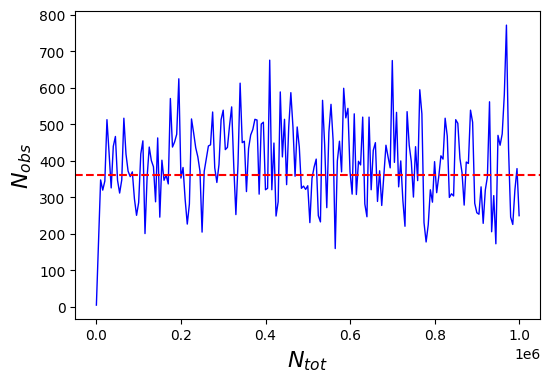

In [10]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

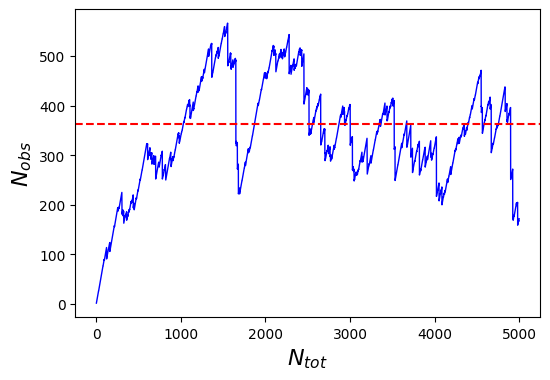

In [11]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") < 5000).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

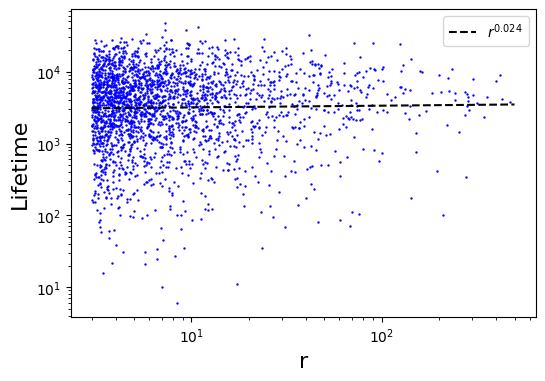

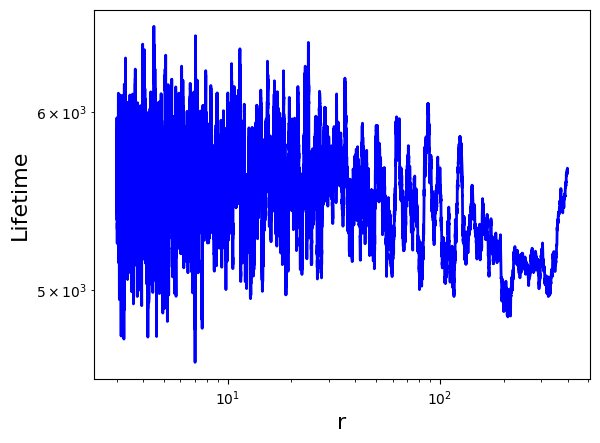

In [12]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 0.25)
# lifetimes = lifetimes[lifetimes.radius < 20]

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    lifetimes.radius,
    np.exp(fitted_model.predict(lifetimes)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

# # Smoothed plot
n_smoothing = 500
min_periods = 100
smoothed_radii = lifetimes.radius.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
smoothed_lifetimes = lifetimes.lifetime.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
plt.plot(
    smoothed_radii,
    smoothed_lifetimes,
    c="blue",
    label="Smoothed",
    lw=2
)
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)

plt.xscale("log")
plt.yscale("log")

plt.savefig(f"figures/{scenario_name}_lifetimes_smoothed.png", bbox_inches="tight")
plt.show()

In [13]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     74.98
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           4.77e-18
Time:                        19:21:43   Log-Likelihood:            -4.1452e+05
No. Observations:              250020   AIC:                         8.290e+05
Df Residuals:                  250018   BIC:                         8.291e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.0102      0.006   1276.651      0.000       7.998       8.023
np.log(radius)     0.0240      0.003      8.659      0.000       0.019       0.029
==============================================================================
Omnibus:                    48761.429   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           105926.272
Skew:                          -1.137   Prob(JB):                         0.00
Kurtosis:                       5.235   Cond. No.                         6.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

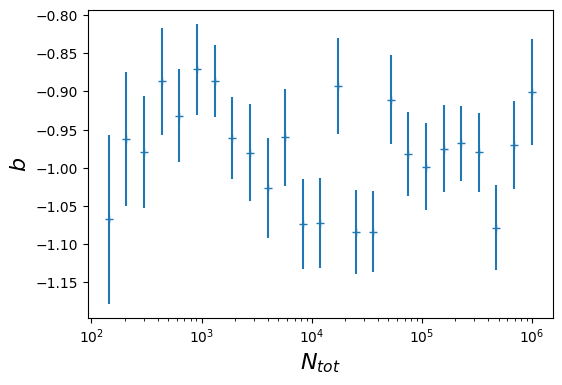

In [14]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

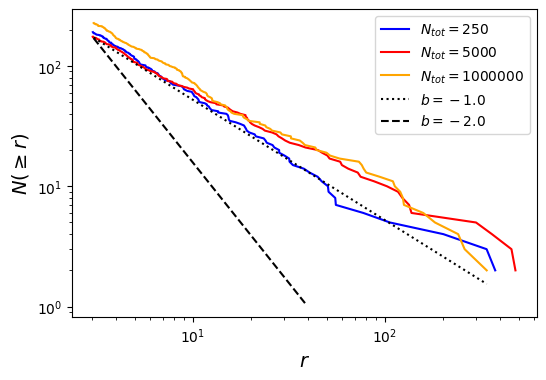

In [15]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[250, 5000, 1000000])

equilibrium_slope = -2.0
equilibrium_intercept = min(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -1.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)

fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")
plt.show()

AD line: 0.36501037650602414


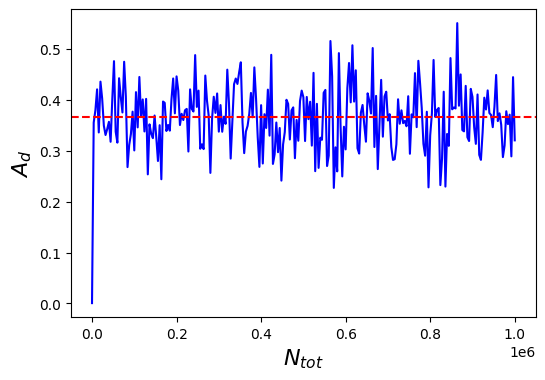

log_mnnd line: 1.6867802593880206


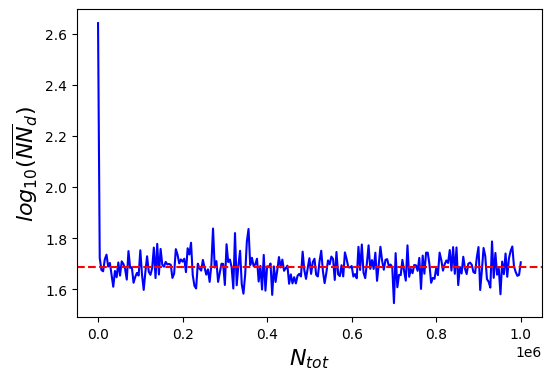

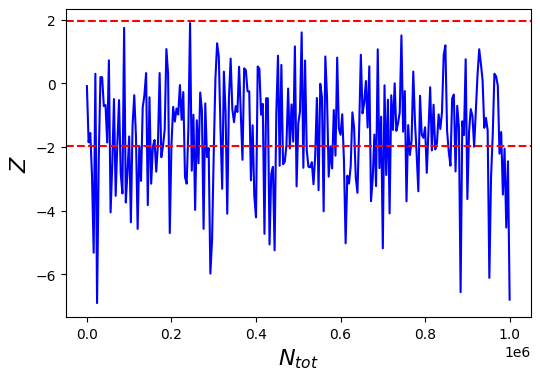

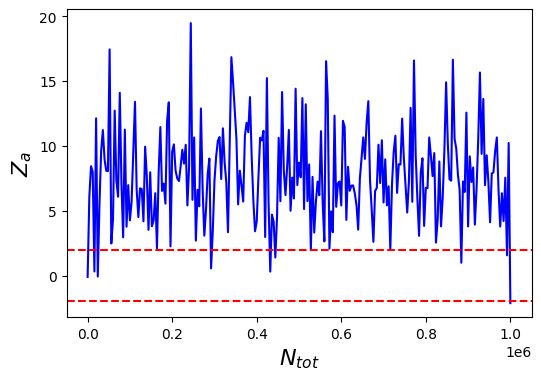

radius_mean line: 15.404354192514214


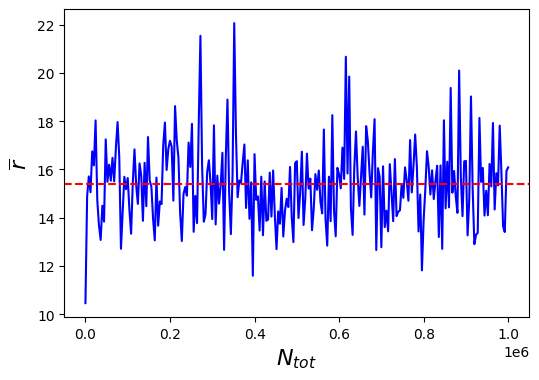

radius_stdev line: 35.50058068489003


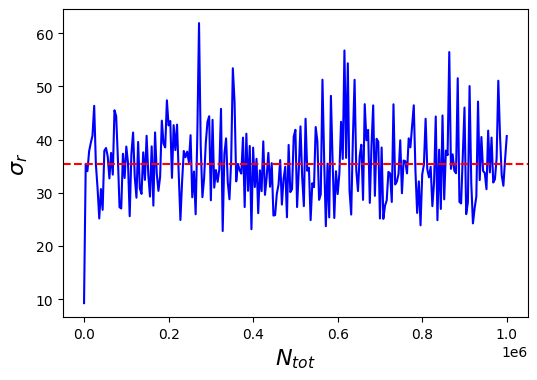

In [16]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=8000
)

## Steep slope

In [17]:
scenario_name = "steep_slope"
selected_slope = -4
selected_mrp = 0.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
0,9,0.5,1.5,23,-4.0,250,2000
2,9,0.5,1.5,22,-4.0,250,2000
10,3,0.5,1.5,54,-4.0,250,2000
11,9,0.5,1.5,21,-4.0,250,2000


nobs line: 557.0


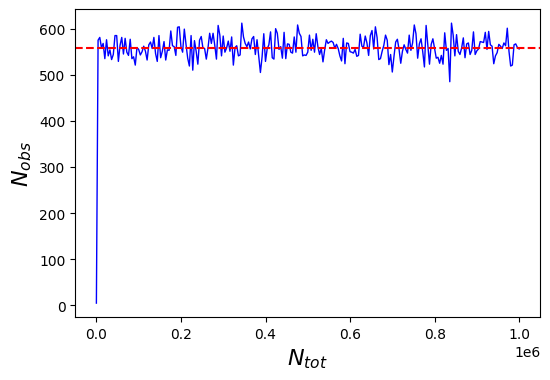

In [18]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

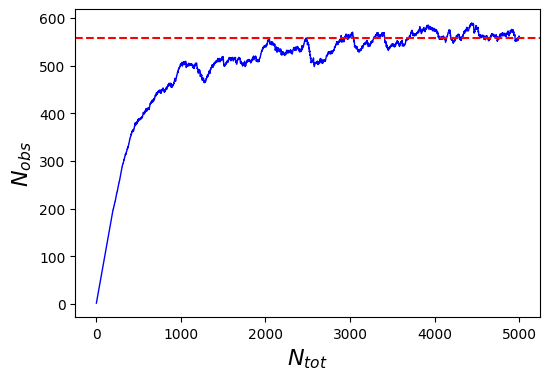

In [19]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") < 5000).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

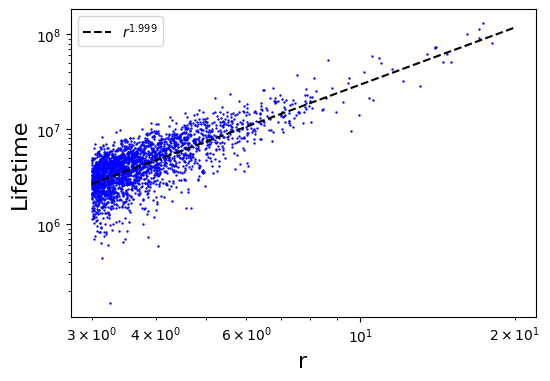

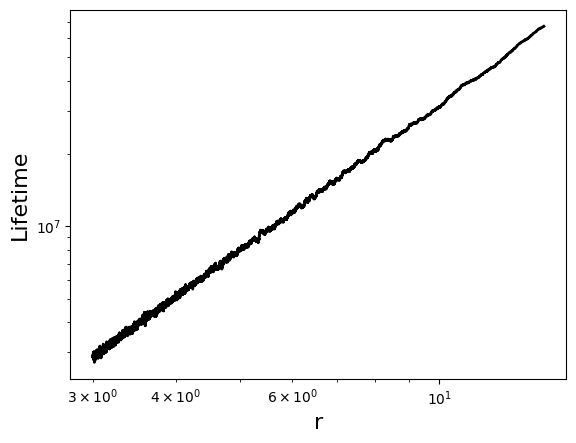

In [20]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 0.25)
lifetimes = lifetimes[lifetimes.radius < 20]

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.01)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    lifetimes.radius,
    np.exp(fitted_model.predict(lifetimes)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

# # Smoothed plot
n_smoothing = 500
min_periods = 100
smoothed_radii = lifetimes.radius.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
smoothed_lifetimes = lifetimes.lifetime.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
plt.plot(
    smoothed_radii,
    smoothed_lifetimes,
    c="black",
    label="Smoothed",
    lw=2
)
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)

plt.xscale("log")
plt.yscale("log")

plt.savefig(f"figures/{scenario_name}_lifetimes_smoothed.png", bbox_inches="tight")
plt.show()

In [21]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 3.378e+05
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:22:03   Log-Likelihood:            -1.3953e+05
No. Observations:              249947   AIC:                         2.791e+05
Df Residuals:                  249945   BIC:                         2.791e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.5980      0.005   2674.834      0.000      12.589      12.607
np.log(radius)     1.9986      0.003    581.220      0.000       1.992       2.005
==============================================================================
Omnibus:                    82787.289   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           718824.712
Skew:                          -1.349   Prob(JB):                         0.00
Kurtosis:                      10.858   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

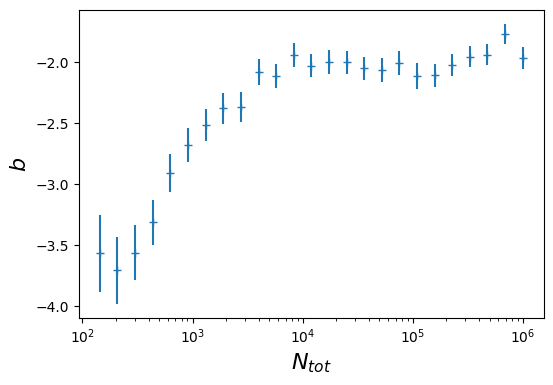

In [22]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

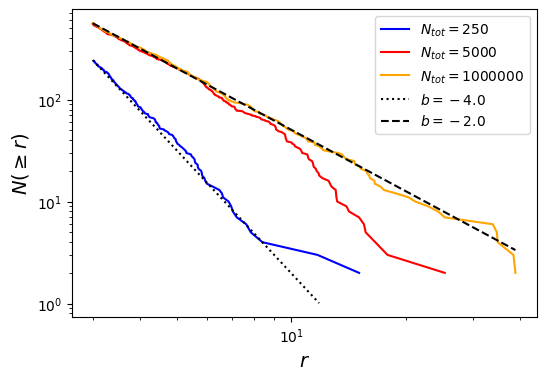

In [23]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[250, 5000, 1000000])

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -4.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

AD line: 0.026569244444444445


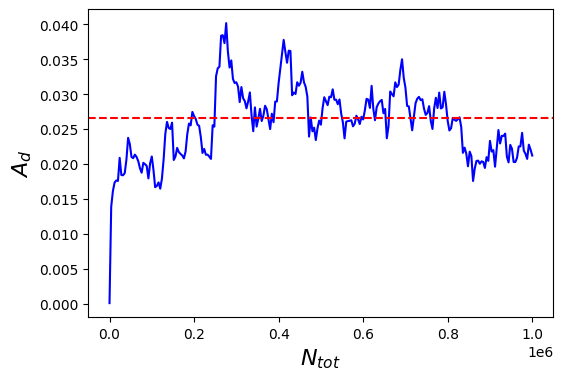

log_mnnd line: 1.6352565934857806


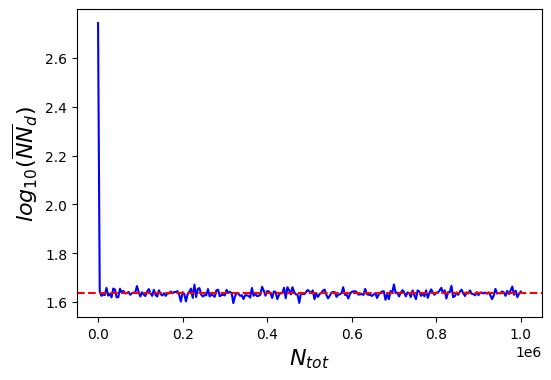

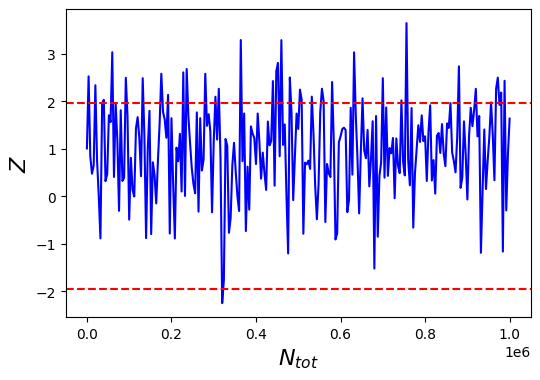

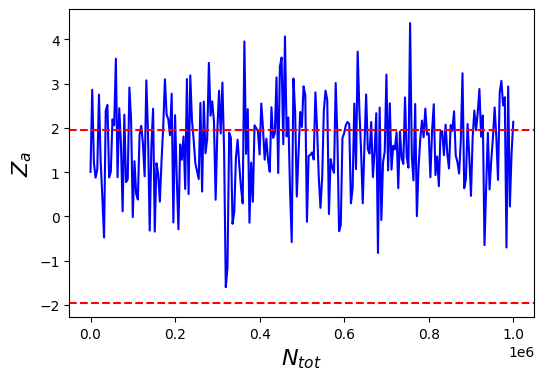

radius_mean line: 5.820263018129227


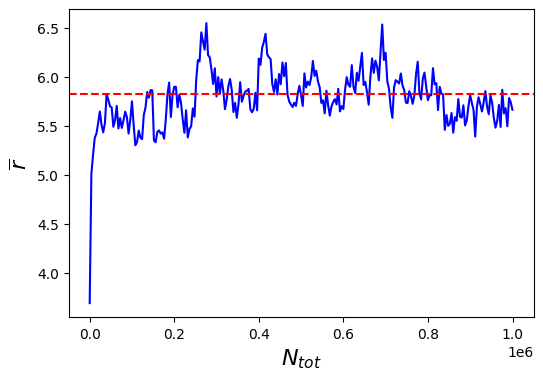

radius_stdev line: 5.1796057401383795


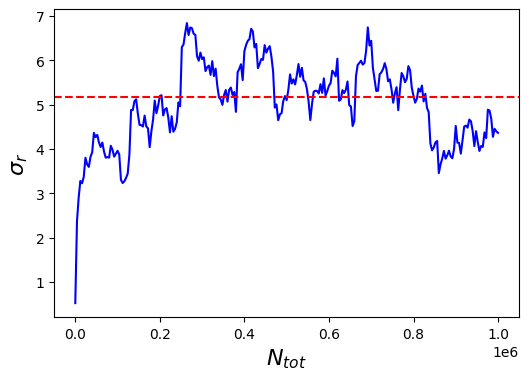

In [24]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=100000
)

## High destruction, b = -2.5

In [25]:
scenario_name = "high_destruction"
selected_slope = -2.5
selected_mrp = 0.75

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
3,15,0.75,1.9,41,-2.5,250,2000
9,15,0.75,1.9,42,-2.5,250,2000
13,15,0.75,1.9,43,-2.5,250,2000


nobs line: 1080.0


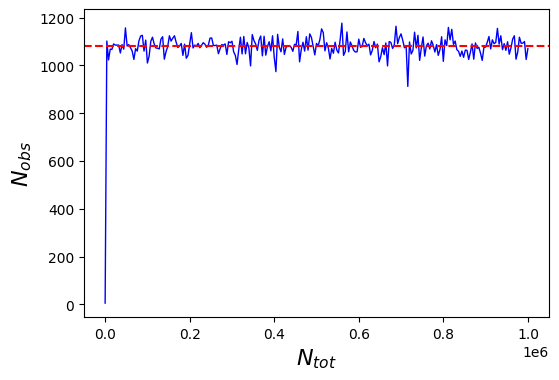

In [26]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue",
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

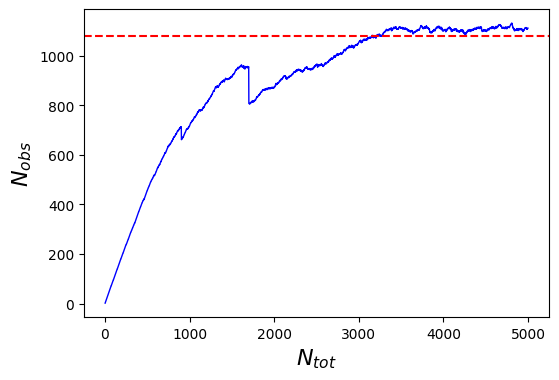

In [27]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") < 5000).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

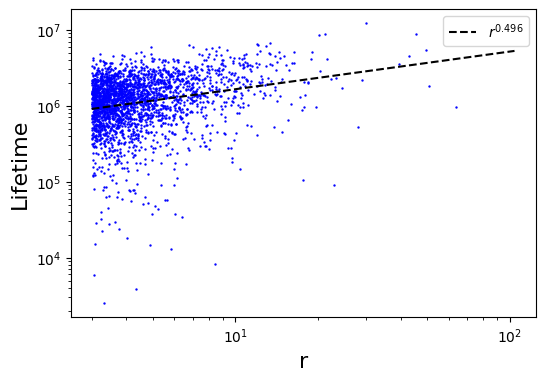

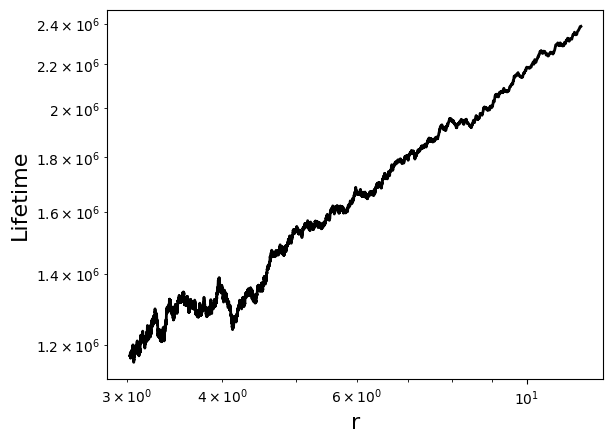

In [28]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 0.01)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.25)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    s=.5,
    c="blue"
)

# Fit the line in log space
fitted_model = sm.OLS(np.log(lifetimes.lifetime), sm.add_constant(np.log(lifetimes.radius))).fit()
const, fitted_slope = fitted_model.params

fitted = lifetimes.radius ** fitted_slope * np.e**const 
plt.plot(
    lifetimes.radius,
    fitted,
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

# # Smoothed plot
n_smoothing = 500
min_periods = 100
smoothed_radii = lifetimes.radius.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
smoothed_lifetimes = lifetimes.lifetime.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
plt.plot(
    smoothed_radii,
    smoothed_lifetimes,
    c="black",
    label="Smoothed",
    lw=2
)
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)

plt.xscale("log")
plt.yscale("log")

plt.savefig(f"figures/{scenario_name}_lifetimes_smoothed.png", bbox_inches="tight")
plt.show()

In [29]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lifetime   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     532.1
Date:                Sun, 15 Sep 2024   Prob (F-statistic):          8.45e-115
Time:                        19:22:21   Log-Likelihood:                -12849.
No. Observations:               10160   AIC:                         2.570e+04
Df Residuals:                   10158   BIC:                         2.572e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1738      0.033    395.417      0.000      13.108      13.239
radius         0.4960      0.022     23.068      0.000       0.454       0.538
==============================================================================
Omnibus:                     4232.111   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26835.651
Skew:                          -1.886   Prob(JB):                         0.00
Kurtosis:                      10.011   Cond. No.                         8.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

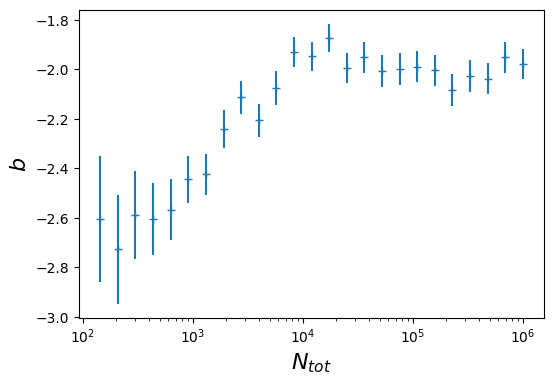

In [30]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

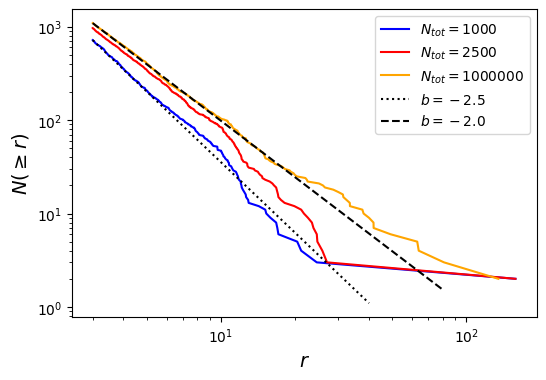

In [31]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[1000, 2500, 1000000])

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

AD line: 0.08198414111111112


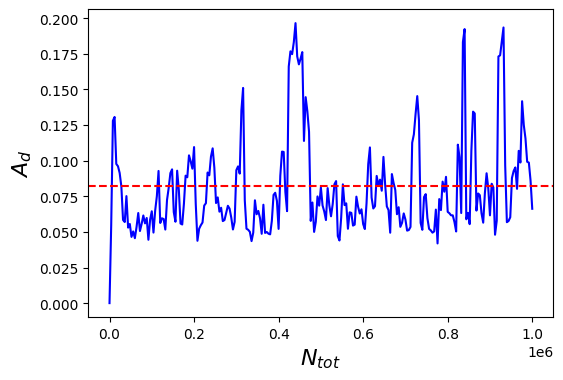

log_mnnd line: 1.5203426052470528


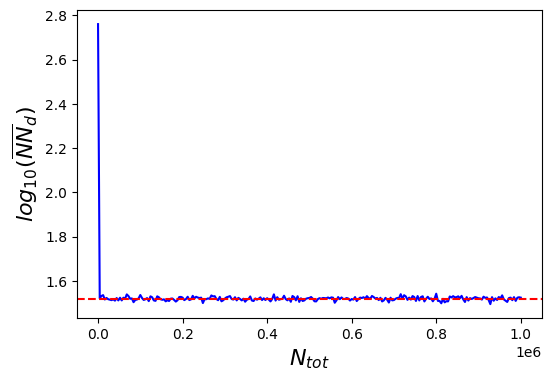

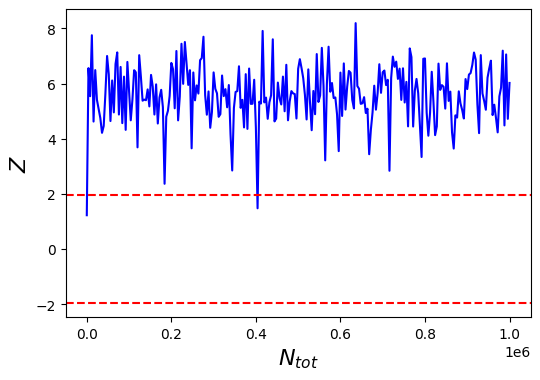

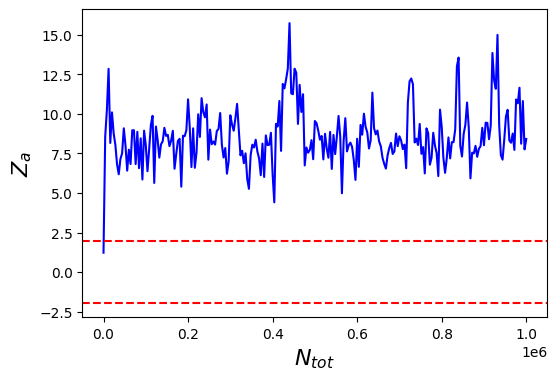

radius_mean line: 6.00964039468546


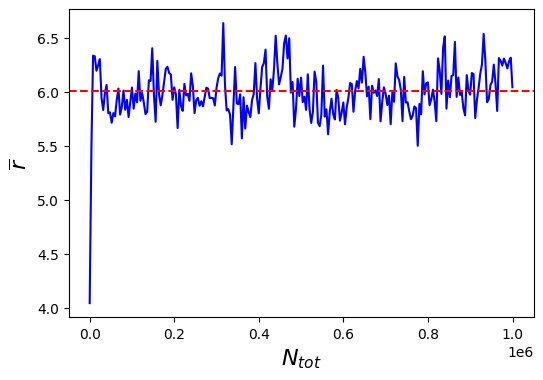

radius_stdev line: 7.736671959755058


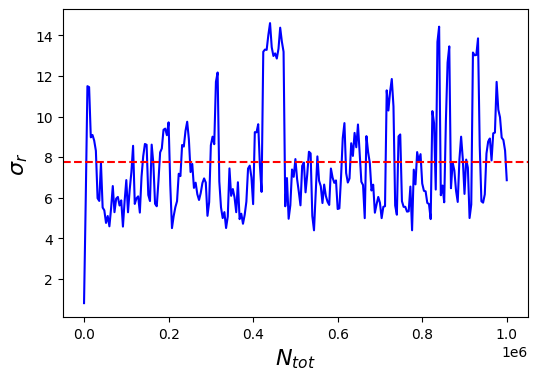

In [32]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=100000
)

## Low destruction, slope = -2.5

Ntot/nobs plot and Z/Za plots restricted in range to show Z/Za reaching significance before "saturation"

In [33]:
scenario_name = "low_destruction"
selected_slope = -2.5
selected_mrp = 0.25

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
4,3,0.25,1.1,31,-2.5,250,2000
8,3,0.25,1.1,32,-2.5,250,2000
14,3,0.25,1.1,33,-2.5,250,2000


nobs line: 24704.0


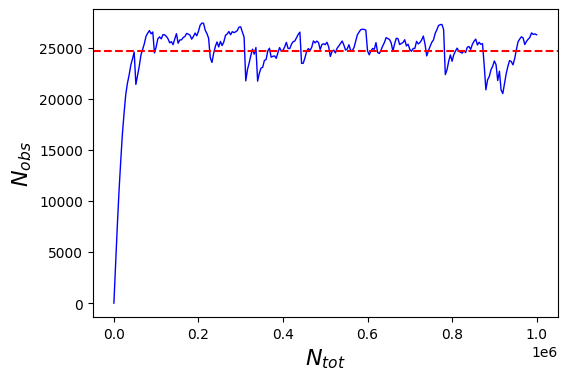

In [34]:
n_samples = 250
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

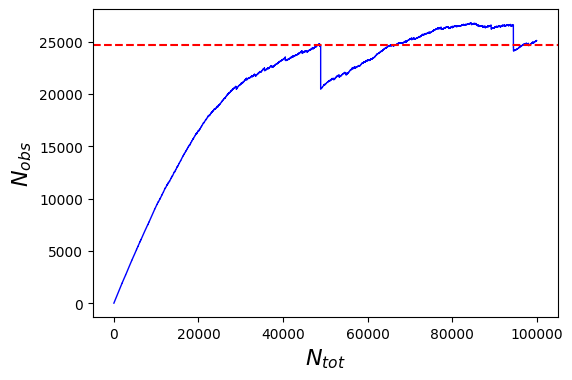

In [35]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") < 100000).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

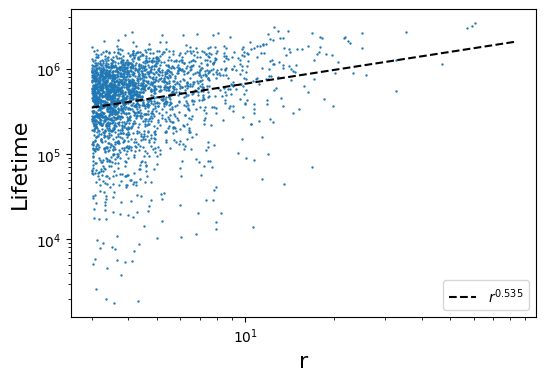

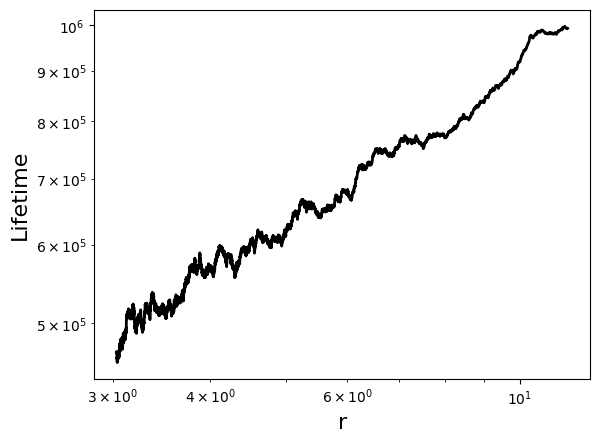

In [36]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 0.01)

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.25)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    s=.5
)

# Fit the line in log space
fitted_model = sm.OLS(np.log(lifetimes.lifetime), sm.add_constant(np.log(lifetimes.radius))).fit()
const, fitted_slope = fitted_model.params

fitted = lifetimes.radius ** fitted_slope * np.e**const 
plt.plot(
    lifetimes.radius,
    fitted,
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

# # Smoothed plot
n_smoothing = 500
min_periods = 100
smoothed_radii = lifetimes.radius.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
smoothed_lifetimes = lifetimes.lifetime.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
plt.plot(
    smoothed_radii,
    smoothed_lifetimes,
    c="black",
    label="Smoothed",
    lw=2
)
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
auk8tamE!
auk8tamE
plt.xscale("log")
plt.yscale("log")

plt.savefig(f"figures/{scenario_name}_lifetimes_smoothed.png", bbox_inches="tight")
plt.show()

In [37]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lifetime   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     453.3
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           2.37e-98
Time:                        19:22:38   Log-Likelihood:                -13534.
No. Observations:                9704   AIC:                         2.707e+04
Df Residuals:                    9702   BIC:                         2.709e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1765      0.039    313.298      0.000      12.100      12.253
radius         0.5354      0.025     21.292      0.000       0.486       0.585
==============================================================================
Omnibus:                     3497.370   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15538.070
Skew:                          -1.721   Prob(JB):                         0.00
Kurtosis:                       8.156   Cond. No.                         8.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

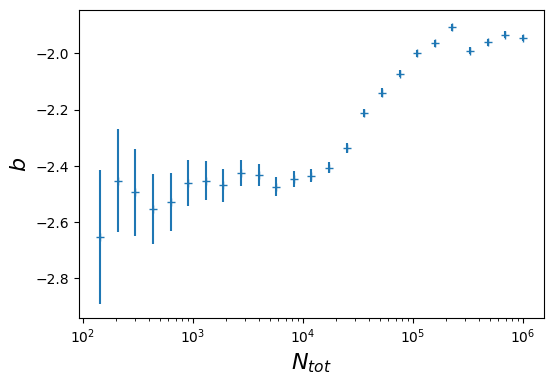

In [38]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

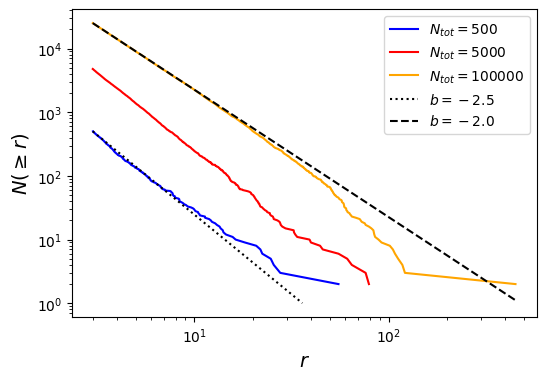

In [39]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 5000, 100000])

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

AD line: 0.8736903500000002


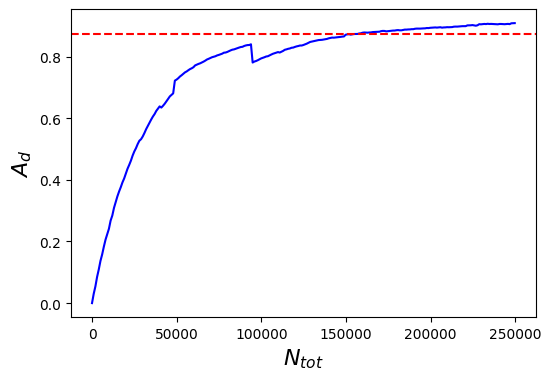

log_mnnd line: 0.8232627413486195


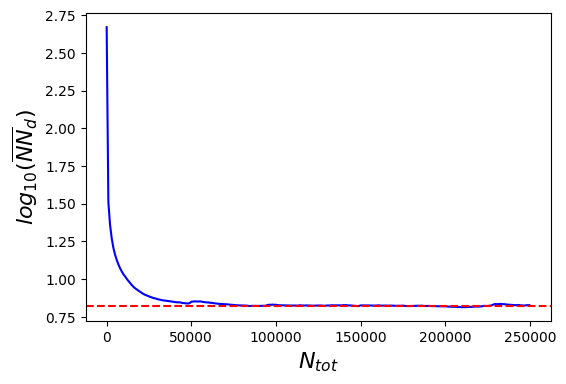

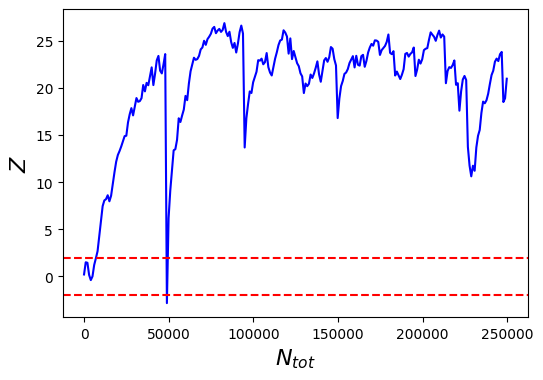

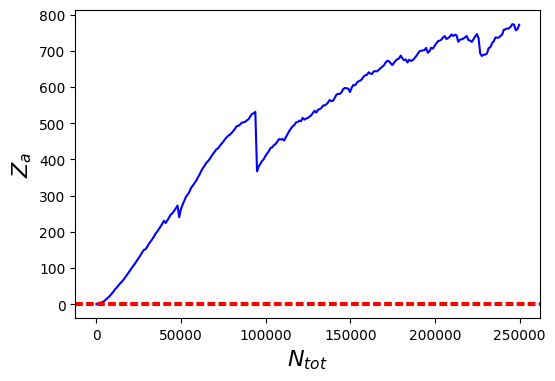

radius_mean line: 6.011623655307633


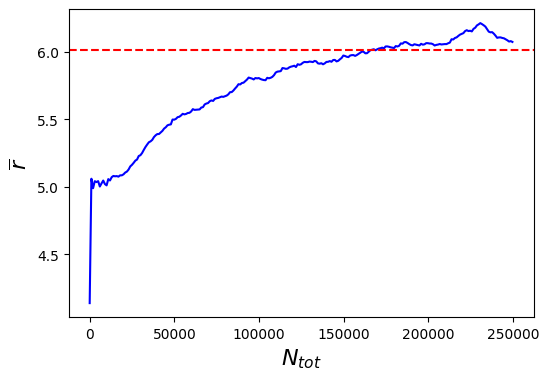

radius_stdev line: 6.786397234349411


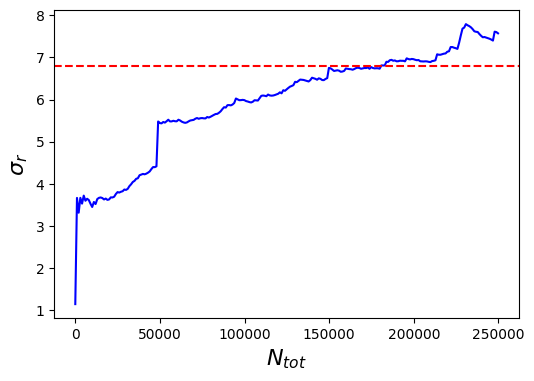

In [40]:
n_samples = 250
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
    & (F.col("ntot") < 250000)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=100000
)

## Extended simulation, shallow slope

In [41]:
base_path = "/data/saturation/thesis_run_20240726_long_shallow_slope"

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
    "mnnd",
    "z",
    "za",
    "radius_mean",
    "radius_stdev",
    F.col("areal_density").alias("ad"),
    F.log10("mnnd").alias("log_mnnd"),
    F.log10("nobs").alias("log_nobs"),
    F.log10("ntot").alias("log_ntot"),
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [42]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/thesis*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

In [43]:
scenario_name = "long_shallow_slope"
selected_slope = -1
selected_mrp = 0.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp)]
selected_simulation_id = filtered.simulation_id.iloc[0]
filtered

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
0,9,0.5,1.5,1,-1.0,250,2000


nobs line: 399.0


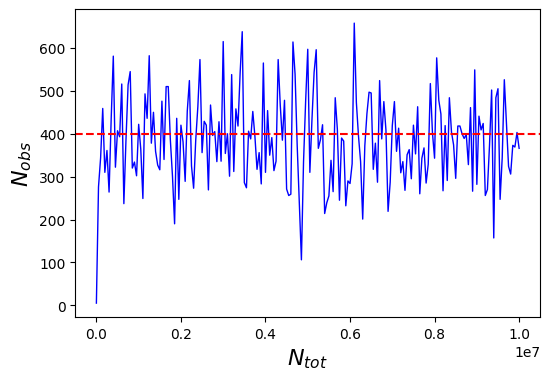

In [44]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

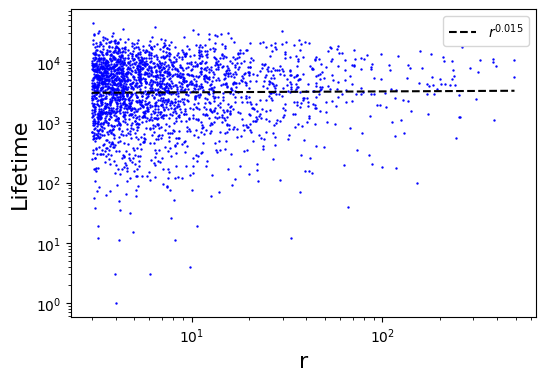

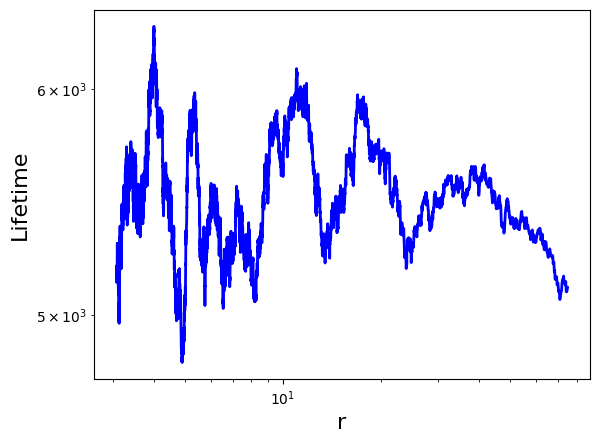

In [45]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 0.001)
# lifetimes = lifetimes[lifetimes.radius < 20]

plt.figure(figsize=(6, 4))

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.25)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    lifetimes.radius,
    np.exp(fitted_model.predict(lifetimes)),
    ls="dashed",
    c="black",
    label=f"$r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.legend()

plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

# # Smoothed plot
n_smoothing = 500
min_periods = 100
smoothed_radii = lifetimes.radius.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
smoothed_lifetimes = lifetimes.lifetime.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
plt.plot(
    smoothed_radii,
    smoothed_lifetimes,
    c="blue",
    label="Smoothed",
    lw=2
)
plt.xlabel("r", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)

plt.xscale("log")
plt.yscale("log")

plt.savefig(f"figures/{scenario_name}_lifetimes_smoothed.png", bbox_inches="tight")
plt.show()

In [46]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.177
Date:                Sun, 15 Sep 2024   Prob (F-statistic):              0.278
Time:                        19:22:58   Log-Likelihood:                -16525.
No. Observations:               10006   AIC:                         3.305e+04
Df Residuals:                   10004   BIC:                         3.307e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.0176      0.031    256.888      0.000       7.956       8.079
np.log(radius)     0.0151      0.014      1.085      0.278      -0.012       0.042
==============================================================================
Omnibus:                     2032.885   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4715.535
Skew:                          -1.148   Prob(JB):                         0.00
Kurtosis:                       5.458   Cond. No.                         6.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

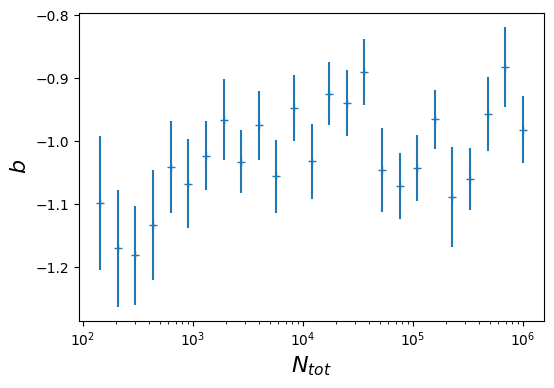

In [47]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states, selected_simulation_id)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

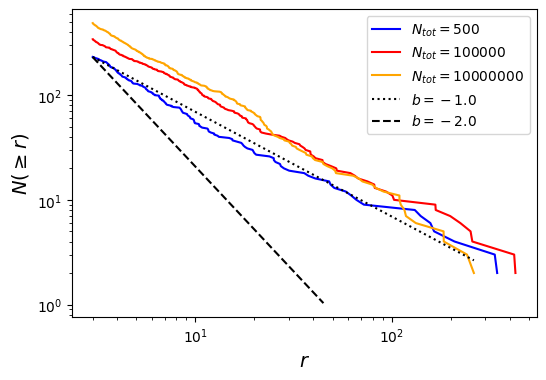

In [48]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 100000, int(1e7)])

equilibrium_slope = -2.0
equilibrium_intercept = min(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -1.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

AD line: 0.36063178768844223


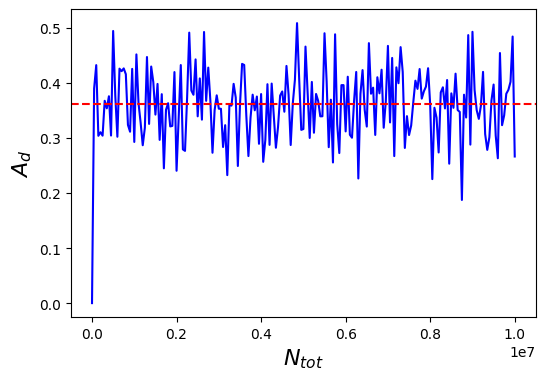

log_mnnd line: 1.6937624181387148


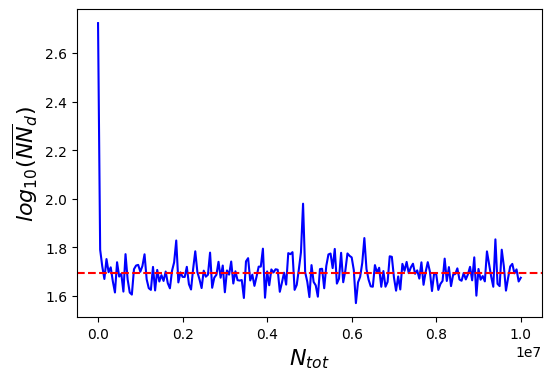

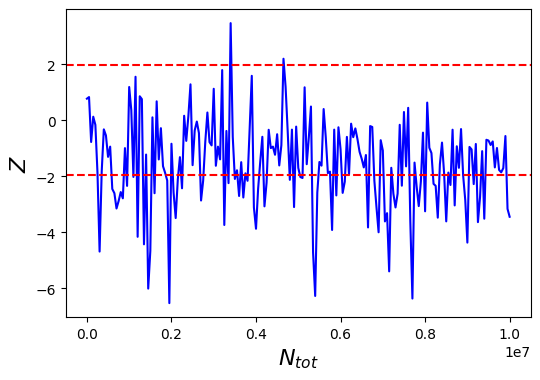

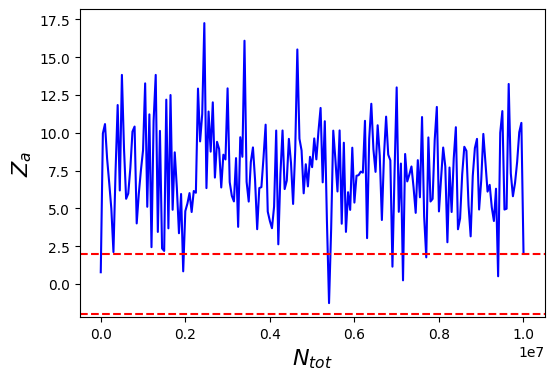

radius_mean line: 15.72024497622627


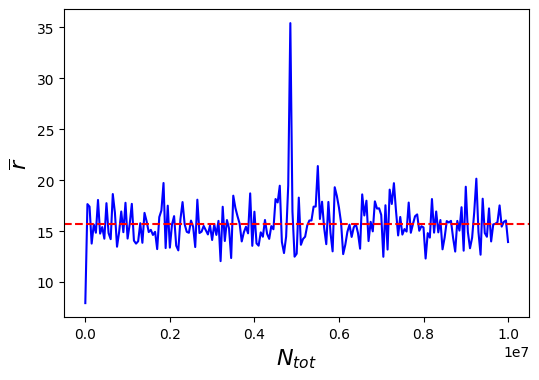

radius_stdev line: 35.78382770517013


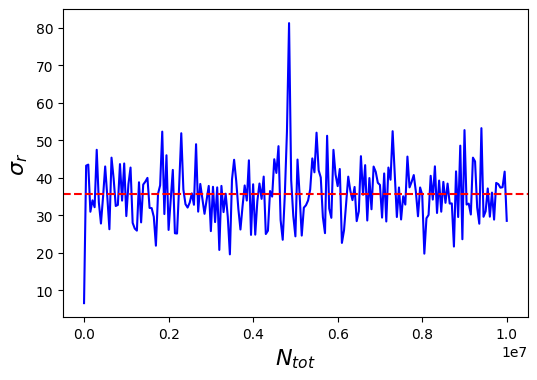

In [49]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=100000
)